# Forcast the number of Passengers for the next 3 years

### Table of contents:

- Import the necessary dependencies
- Load the data
- Explore and identify the nature of the series 
- Identify the optimal combination of parameters for the model
- Train the SARIMA model
- Investigate the residual plot of the model
- Test The model
- Forcast the future


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas import datetime

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)


plt.style.use('fivethirtyeight')

In [2]:
#Load the data
airline = pd.read_csv('AirPassengers.csv',index_col ='Month', parse_dates = True)

In [3]:
#shape of the data
airline.shape

(144, 1)

In [4]:
#display thefirst 5 rows
airline.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [5]:
#Display the last 5 rows
airline.tail()

,#Passengers
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [6]:
airline.isna().sum()

#Passengers    0
dtype: int64

In [10]:
airline.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


## Visualize the Data

#### #Passengers Distribution

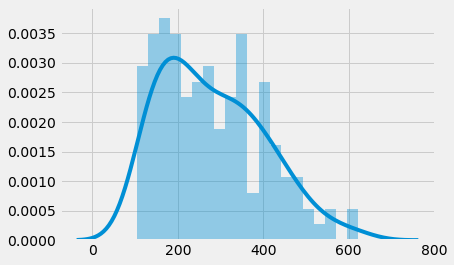

In [11]:
sns.distplot(airline,bins=20)

#### Plot yearly and monthly values as BoxPlot

In [12]:
airline['year'] = [d.year for d in airline.index]
airline['month'] = [d.strftime('%b') for d in airline.index] 
years = airline['year'].unique()

In [13]:
airline.head()

,#Passengers,year,month
Month,,,
1949-01-01,112,1949,Jan
1949-02-01,118,1949,Feb
1949-03-01,132,1949,Mar
1949-04-01,129,1949,Apr
1949-05-01,121,1949,May


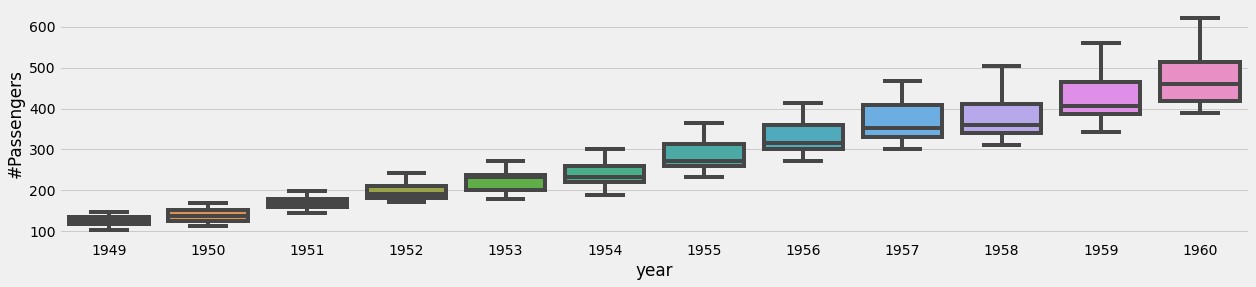

In [14]:
#Plot of yearly values
plt.figure(figsize=(19,4))
sns.boxplot(x='year', y='#Passengers', data=airline)

>the chart above exhibits a positive trend

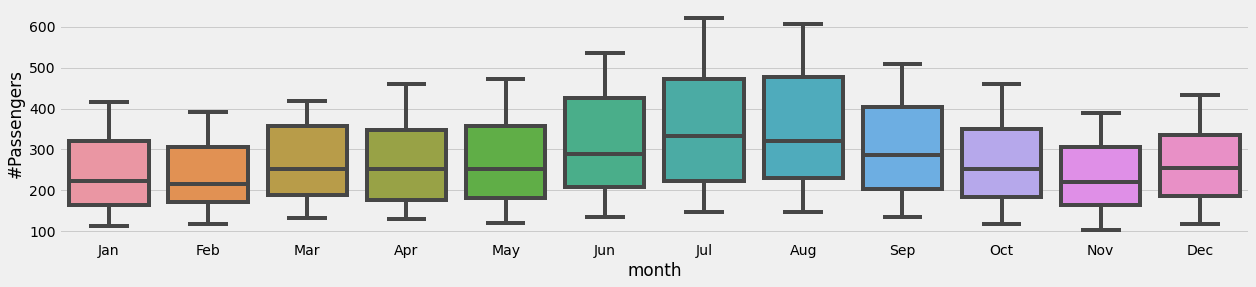

In [15]:
##Plot of monthly values
plt.figure(figsize=(19,4))
sns.boxplot(x='month', y='#Passengers', data=airline)

> The series that we're dealing with has a seasonal component

In [16]:
airline = airline[['#Passengers']]

#### Plotting the number of Passengers  over time

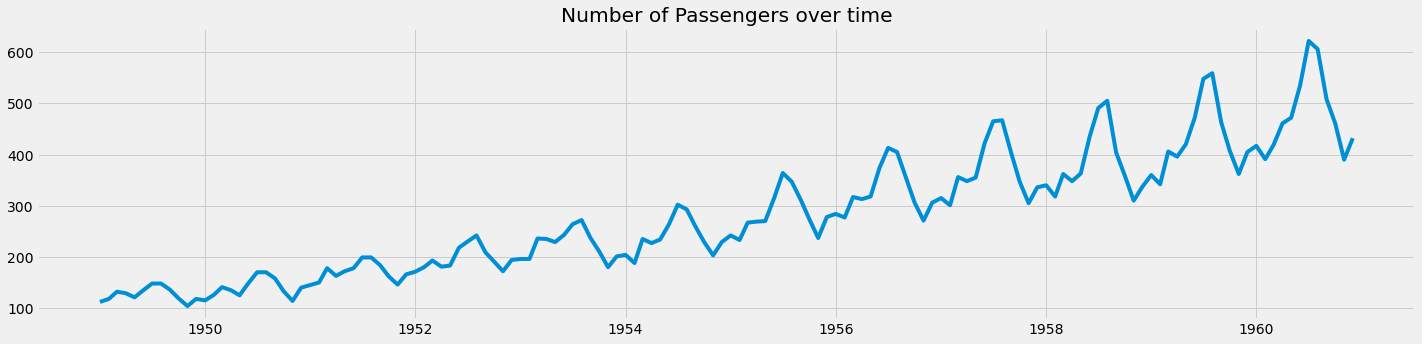

In [34]:
plt.figure(figsize=(22,5))
plt.plot(airline['#Passengers'])
plt.title('Number of Passengers over time')
plt.show();

- Here we can see there is an upward trend
- Based off the previous chart, it looks like the trend in these earlier years is slightly increasing at a higher rate than just linear
- We also observe some kind of pattern that repeat after each period of time
- Based on that we can infer that the series in not stationnary

## Time Series Decomposition

Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

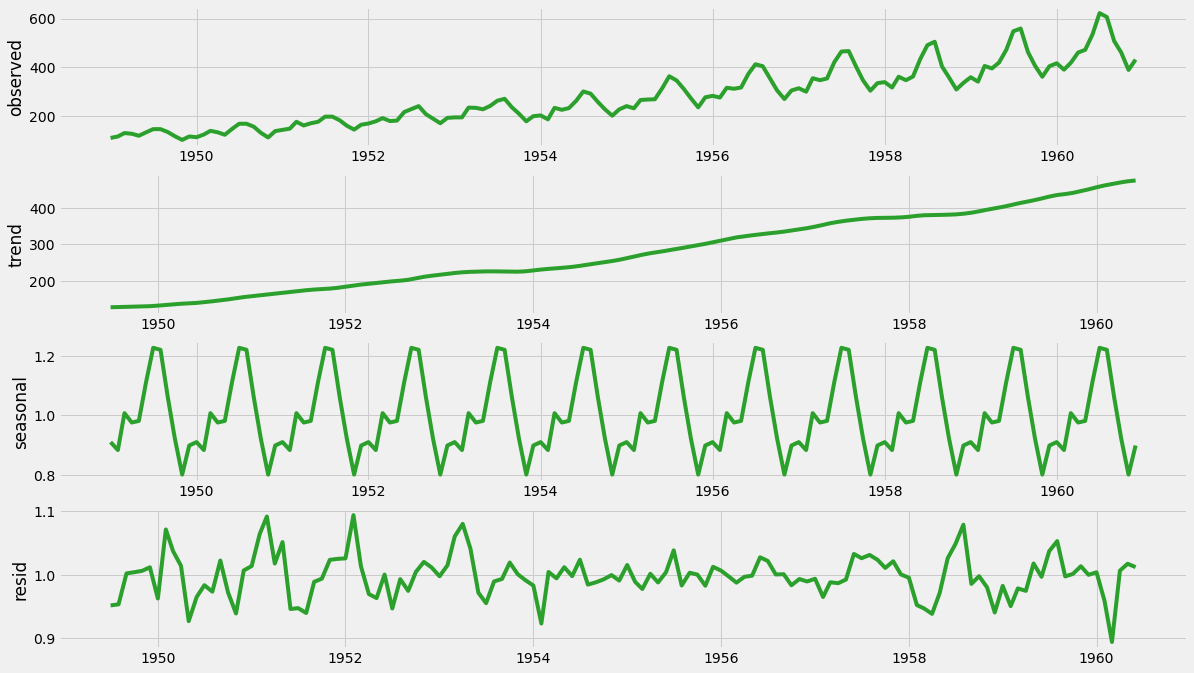

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(airline['#Passengers'], model='multiplicative')

#result.plot()

observed = result.observed
trend = result.trend
seasonal = result.seasonal
resid = result.resid

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(18,11))

ax1.plot(observed,'tab:green')
ax1.set_ylabel('observed')
ax2.plot(trend,'tab:green')
ax2.set_ylabel('trend')
ax3.plot(seasonal,'tab:green')
ax3.set_ylabel('seasonal')
ax4.plot(resid,'tab:green')
ax4.set_ylabel('resid')

plt.show()

We can see that the trend and seasonality information extracted from the sales time series does seem reasonable. The residuals are also interesting, showing periods of high variability in the early and later years of the series.

## Testing For Stationarity

WHY? beacuse one of the requirements for ARIMA is that the time series should be stationary. A stationary series is one where the properties do not change over time.
#### Test1: by computing and plotting both the rolling mean and standard deviation

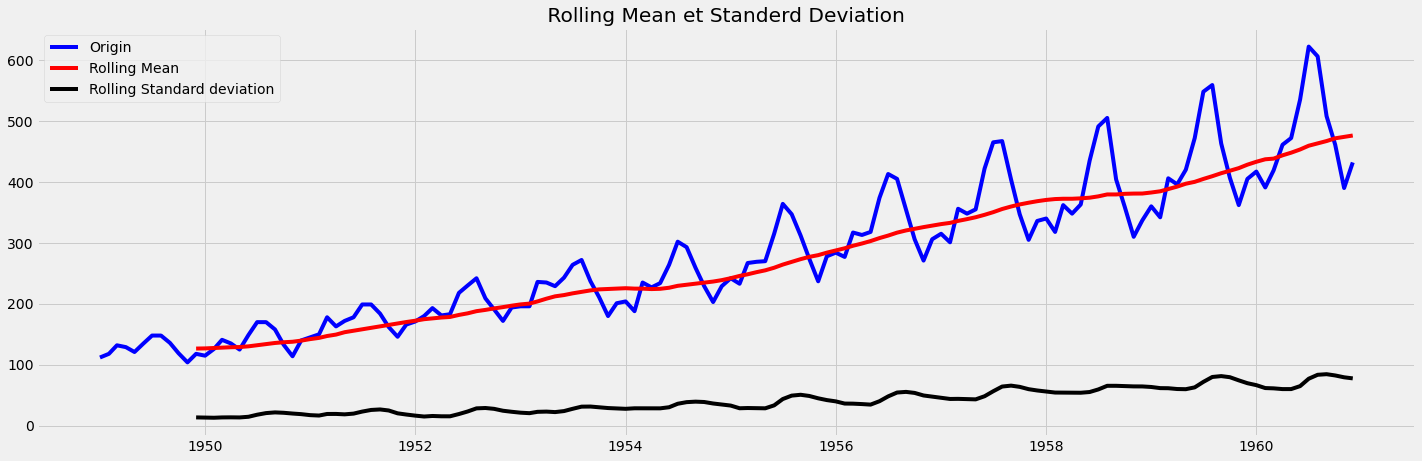

In [19]:
rolling_mean = airline['#Passengers'].rolling(window = 12).mean()
rolling_std  = airline['#Passengers'].rolling(window = 12).std()

plt.figure(figsize=(22,7))
plt.plot(airline['#Passengers'], color = 'blue', label = 'Origin')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Standard deviation')
plt.legend(loc = 'best')
plt.title(' Rolling Mean et Standerd Deviation ')
plt.show()


- The rolling mean and standard deviation aren't not constant over time, they kept increasing 


#### Test 2: Augmented Dickey-Fuller Test
- We'll use the Augumented Dickey Fuller (ADF) test to check if the sales series is stationary.
- The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value >= 0.05 we'll need to find the order of differencing.
- Larger p value could indicate presence of certain trends(varying mean) or seasonality as well.


In [20]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(series):
    result = adfuller(series)
    if result[1] > 0.05:
          print('---The data has a unit root and is non-stationary---')
          print(f'ADF Statistic: {result[0]}')
          print('p-value:',result[1])
    else :
        print('---the data does not have a unit root and is stationary---')
        print(f'ADF Statistic: {result[0]}')
        print('p-value:',result[1])

test_stationarity(airline['#Passengers'])

---The data has a unit root and is non-stationary---
ADF Statistic: 0.8153688792060423
p-value: 0.9918802434376409


The output above shows that the p-value is greater than the significance level of 0.05, so we fail to reject the null hypothesis. The series is not stationary and requires differencing.


# SARIMA

Now that we’ve analyzed the data, we can clearly see we have a time series with a seasonal component, so it make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

### Auto-ARIMA

- to figure out automatically the order of the ARIMA
- The function basically uses something called as the AIC score to judge how good a particular order model is. It simply tries to minimize the AIC score

In [21]:
from pmdarima import auto_arima

stepwise_fit = auto_arima(airline['#Passengers'], start_p = 1, start_q = 1, test='adf',
                          max_p = 3, max_q = 3, m = 12, # set the frequency m=12 for month
                          start_P = 0, seasonal = True,
                          d = None, D = 1, trace = True,
                          error_action ='ignore',   # we don't want to know if an order does not work
                          suppress_warnings = True,  # we don't want convergence warnings
                          stepwise = True)           # set to stepwise
# To print the summary
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.23 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.10 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.19 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.04 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.30 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=2.54 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.42 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.19 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.69 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=1.13 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.41 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.25 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=3.26 sec
 ARIMA(0,1,1)(1,1,1)[12]     

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                             Mon, 29 Mar 2021   AIC                           1019.178
Time:                                     13:34:17   BIC                           1030.679
Sample:                                          0   HQIC                          1023.851
                                             - 144                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.944      0.000      -0.507      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1910      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4481     15.527      8.402      0.000     100.017     160.880
===================================================================================
Ljung-Box (Q):                       53.71   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.07   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **The negative infinity in AIC infers very overfitted model in the model selection. It is fortunate that your stepAIC was stopped. A working demo below.**
- This minimum value AIC may or may not be negative.

>We can see the best SARIMA model seems to be of the order (0,1,1)(2,1,0,12) with the minimum AIC score=1021.032. With this knowledge we can finally proceed to train and fit the model to start making prediction!


## Interpreting the residual plots in SARIMA model

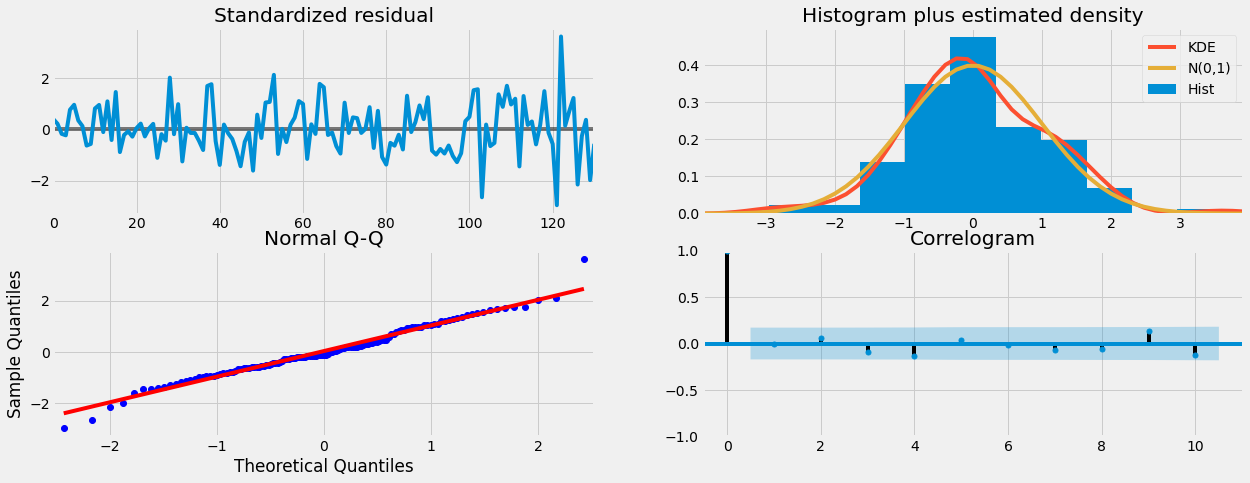

In [22]:
stepwise_fit.plot_diagnostics(figsize=(19,7))
plt.show()

**Top left**: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.

**Top Right**: The density plot suggest normal distribution with mean zero.

**Bottom left**: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.

**Bottom Right**: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.

Overall, it seems to be a good fit.

## Split the data into a train and test set

Before we actually train the model, we have to split the data set into a training and testing section. We do this because we first train the model on the data and keep the testing section hidden from the model. Once model is ready, we ask it to make predictions on the test data and see how well it performs.

In [23]:
# Split data into train / test sets
train = airline.iloc[:len(airline['#Passengers'])-12]
test = airline.iloc[len(airline['#Passengers'])-12:] # set one year(12 months) for testing

In [24]:
print('train length:', len(train))
print('test length:', len(test))

train length: 132
test length: 12


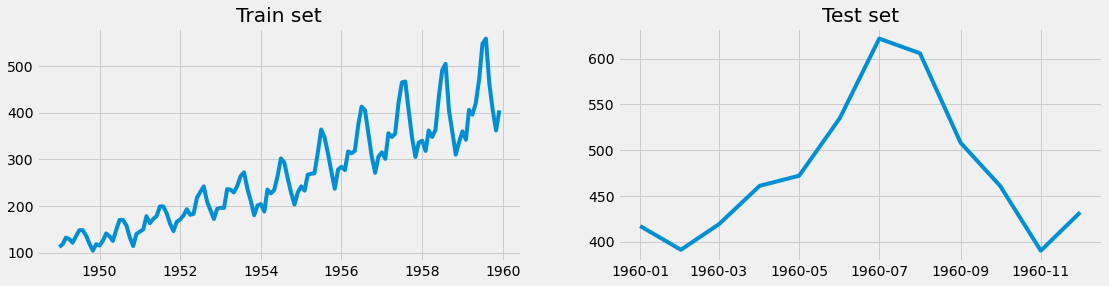

In [25]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(17,4))
ax1.plot(train);ax1.set_title("Train set")
ax2.plot(test);ax2.set_title("Test set")
plt.show()

## Fit SARIMA Model

In [27]:
# Fit a SARIMAX(1, 0, 0)x(1, 1, 0, 12) on the training set
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
model = SARIMAX(train['#Passengers'], 
                order = (0,1,1), 
                seasonal_order =(2, 1, 0, 12))
  
result = model.fit()
result.summary()  

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                         #Passengers   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -446.830
Date:                             Mon, 29 Mar 2021   AIC                            901.659
Time:                                     13:37:04   BIC                            912.776
Sample:                                 01-01-1949   HQIC                           906.173
                                      - 12-01-1959                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2556      0.080     -3.190      0.001      -0.413      -0.099
ar.S.L12      -0.0962      0.090     -1.073      0.283      -0.272       0.080
ar.S.L24       0.1454      0.101      1.444      0.149      -0.052       0.343
sigma2       106.2409     15.243      6.970      0.000      76.364     136.117
===================================================================================
Ljung-Box (Q):                       42.14   Jarque-Bera (JB):                 0.01
Prob(Q):                              0.38   Prob(JB):                         0.99
Heteroskedasticity (H):               1.63   Skew:                             0.01
Prob(H) (two-sided):                  0.12   Kurtosis:                         2.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predictions of ARIMA Model against the test set

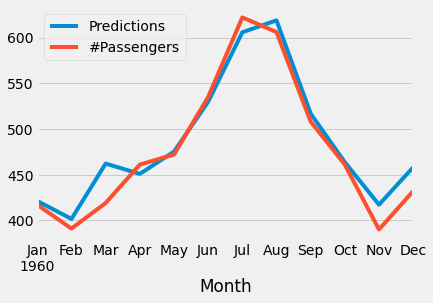

In [28]:
start = len(train)
end = len(train) + len(test) - 1
  
# Predictions for one-year against the test set
predictions = result.predict(start, end, typ = 'levels').rename("Predictions")
  
# plot predictions and actual values
predictions.plot(legend = True)
test['#Passengers'].plot(legend = True)

## Evaluate the model using MSE and RMSE

In [35]:
# Load specific evaluation tools
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
  
# Calculate root mean squared error
print('Root_Mean_Squarred_Error', rmse(test["#Passengers"], predictions))
  
# Calculate mean squared error
print('Mean_Squarred_Error',mean_squared_error(test["#Passengers"], predictions))

Root_Mean_Squarred_Error 18.381013709442296
Mean_Squarred_Error 337.86166498670565


## Forecast using ARIMA Model

/Users/mac/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/mac/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


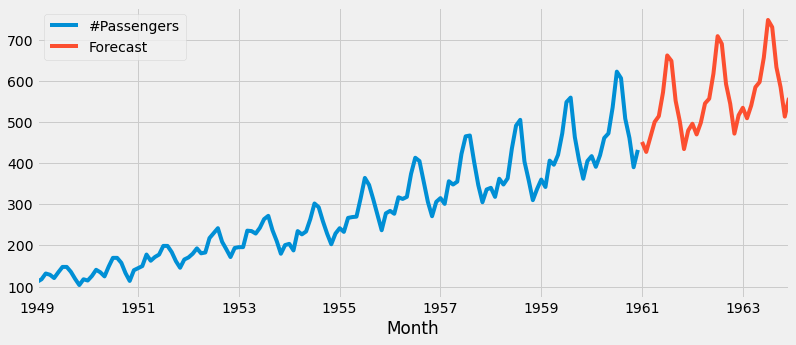

In [36]:
# Train the model on the full dataset
model = model = SARIMAX(airline['#Passengers'], 
                        order = (0,1,1), 
                        seasonal_order =(2, 1, 0, 12))
result = model.fit()
  
# Forecast for the next 3 years
forecast = result.predict(start = len(airline['#Passengers']), 
                          end = (len(airline['#Passengers']) - 1) + 3*12, 
                          typ = 'levels').rename('Forecast')
  
# Plot the forecast values
airline['#Passengers'].plot(figsize = (12, 5), legend = True)
forecast.plot(legend = True)